# Integrating Embeddings with Queries in an Information Retrieval System

## Objective

In this exercise, we will learn how to integrate embeddings with a query to enhance an Information Retrieval (IR) system. We will use both static and contextual embeddings to generate representations of queries and documents, compute their similarities, and rank the documents based on relevance to the query.

---

## Stages Covered

1. **Introduction to Pre-trained Transformer Models**
   - Load and use BERT for contextual embeddings.
   - Load and use Word2Vec for static embeddings.

2. **Generating Text Embeddings**
   - Generate embeddings for queries and documents using BERT.
   - Generate embeddings for queries and documents using Word2Vec.

3. **Computing Similarity Between Embeddings**
   - Compute cosine similarity between query and document embeddings.
   - Rank documents based on similarity scores.

4. **Integrating Embeddings with Queries**
   - Practical implementation of embedding-based retrieval for a given text corpus.

---

## Prerequisites

- TensorFlow
- Hugging Face's Transformers library
- Gensim library
- Scikit-learn library
- A text corpus in the `../data` folder

---

## Exercise

Follow the steps below to integrate embeddings with a query and enhance your IR system.



## Step 0: Verify requirements:

* tensorflow
* transformers
* scikit-learn
* matplotlib
* seaborn

## Importar librerías

In [2]:
import tensorflow as tf
import gensim.downloader as api
from transformers import BertTokenizer, TFBertModel
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed, parallel_backend
from sklearn.metrics.pairwise import cosine_similarity


## Step 1: Download dataset from Kaggle

URL: https://www.kaggle.com/datasets/zynicide/wine-reviews

### Cargar el corpus

In [3]:
wine_df = pd.read_csv('winemag-data_first150k.csv')
print(wine_df.head())
corpus = wine_df['description']

   Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               

## Step 2: Load a Pre-trained Transformer Model

Use the BERT model for generating contextual embeddings and Word2Vec for static embeddings.

### Importar librerías y cargar el modelo preentrenado

In [4]:
word2vec_model = api.load('word2vec-google-news-300') #carga el modelo preentrenado de Word2Vec

### Inicializar el tokenizador de Bert

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased') #importar el modelo de BERT desde el modelo preentrenado 'bert-base-uncased'.

C:\Users\basc6\PycharmProjects\proyect-RI_Soto-Bruce\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Step 3: Generate Text Embeddings

Static Embeddings with Word2Vec

### Generar embeddings Word2Vec a partir de textos

In [6]:
#definir de la funcion para generar embeddings Word2Vec a partir de textos
def generate_word2vec_embeddings(texts):
    embeddings = []
    for text in texts:
        #dividir en texto y convertir a minusculas
        tokens = text.lower().split()
        word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
        #calcular el promedio de vectores de palabras
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(word2vec_model.vector_size))
    return np.array(embeddings)

word2vec_embeddings = generate_word2vec_embeddings(corpus[:10])
print("Word2Vec Embeddings:", word2vec_embeddings)
print("Word2Vec Shape:", word2vec_embeddings.shape)

Word2Vec Embeddings: [[ 0.01978664  0.03414721 -0.00884628 ... -0.01573336  0.06626587
  -0.02784729]
 [ 0.0016861  -0.00124741 -0.00065494 ... -0.04453754  0.06408358
   0.03221512]
 [-0.01758194  0.06408924  0.02408564 ... -0.04092503  0.09110224
   0.01769352]
 ...
 [ 0.02863665  0.00169689 -0.00209213 ... -0.05629005  0.11204083
   0.03335422]
 [ 0.03364817  0.00603784 -0.03152262 ... -0.0193573   0.12829183
  -0.00842387]
 [ 0.01875126  0.03864291  0.00552817 ... -0.07643094  0.06591528
   0.01740489]]
Word2Vec Shape: (10, 300)


Contextual Embeddings with BERT

### Generar embeddings Word2Vec a partir de textos

In [7]:
def generate_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True) #toenizar el texto
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token representation
    return np.array(embeddings).transpose(0,2,1)

bert_embeddings = generate_bert_embeddings(corpus[:10])
print("BERT Embeddings:", bert_embeddings)
print("Word2Vec Shape:", bert_embeddings.shape)

BERT Embeddings: [[[ 0.11967529]
  [-0.48856783]
  [ 0.3645306 ]
  ...
  [-0.4368053 ]
  [ 0.11976132]
  [ 0.18947865]]

 [[-0.0518669 ]
  [-0.36506528]
  [ 0.64746   ]
  ...
  [-0.31474552]
  [ 0.05560082]
  [ 0.51543343]]

 [[-0.73173183]
  [ 0.35088518]
  [-0.01913813]
  ...
  [-0.03388362]
  [ 0.22656628]
  [ 0.3079808 ]]

 ...

 [[-0.35893604]
  [-0.5862952 ]
  [ 0.41342145]
  ...
  [-0.16299427]
  [ 0.33213404]
  [ 0.4952077 ]]

 [[-0.06120773]
  [-0.3186197 ]
  [ 0.6636806 ]
  ...
  [-0.2601146 ]
  [ 0.22982614]
  [ 0.49291313]]

 [[-0.791109  ]
  [-0.3179438 ]
  [ 0.24998933]
  ...
  [-0.42931494]
  [ 0.30838788]
  [-0.06678638]]]
Word2Vec Shape: (10, 768, 1)


## Step 4: Compute Similarity Between Embeddings

Use the scikit-learn library.

In [8]:
# Cosine similarity between Word2Vec embeddings
word2vec_similarity = cosine_similarity(word2vec_embeddings)
print("Word2Vec Cosine Similarity:\n", word2vec_similarity)

# Cosine similarity between BERT embeddings
bert_similarity = cosine_similarity(bert_embeddings.reshape(10,768))
print("BERT Cosine Similarity:\n", bert_similarity)

Word2Vec Cosine Similarity:
 [[1.         0.8253629  0.80511177 0.8419133  0.83916086 0.83854574
  0.8216922  0.8248522  0.84638995 0.8140328 ]
 [0.8253629  1.0000004  0.7915441  0.8704564  0.70442986 0.8919624
  0.85559994 0.9090055  0.82102585 0.8199145 ]
 [0.80511177 0.7915441  0.99999976 0.7813313  0.7663708  0.81088406
  0.76002795 0.7869289  0.7806283  0.82849413]
 [0.8419133  0.8704564  0.7813313  0.99999964 0.7388937  0.8769778
  0.8692663  0.86583847 0.8299481  0.81447786]
 [0.83916086 0.70442986 0.7663708  0.7388937  0.9999998  0.7408403
  0.7264281  0.7543802  0.84104794 0.73225087]
 [0.83854574 0.8919624  0.81088406 0.8769778  0.7408403  1.0000001
  0.86410356 0.9094129  0.8474779  0.8254898 ]
 [0.8216922  0.85559994 0.76002795 0.8692663  0.7264281  0.86410356
  0.99999976 0.87098914 0.8183166  0.7882399 ]
 [0.8248522  0.9090055  0.7869289  0.86583847 0.7543802  0.9094129
  0.87098914 0.9999997  0.86063915 0.83889055]
 [0.84638995 0.82102585 0.7806283  0.8299481  0.84104794

## Step 5: Compare Contextual and Static Embeddings

Analyze and compare the similarity results from both BERT and Word2Vec embeddings.

### Generar la matriz de similitud de tramas

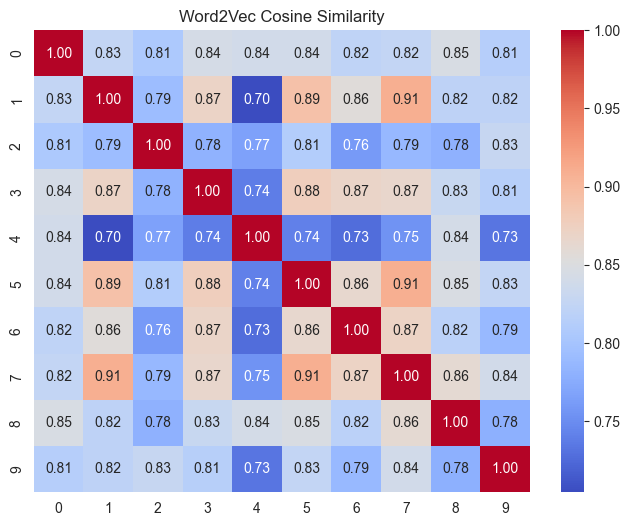

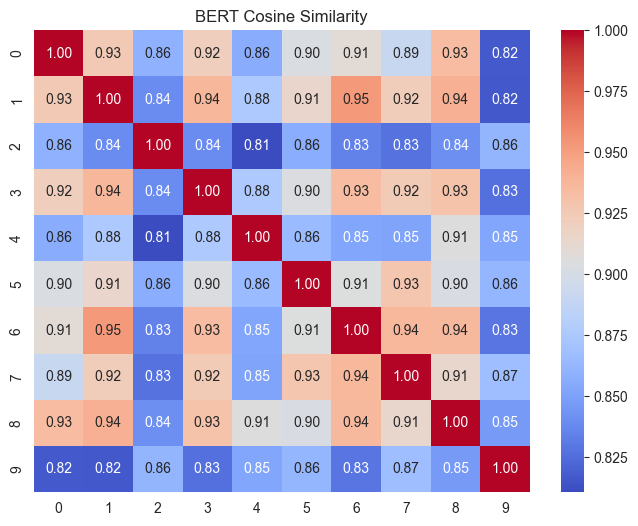

In [9]:
def plot_similarity_matrix(matrix, title, figsize=(8, 6), annotation=True):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=annotation, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_similarity_matrix(word2vec_similarity, "Word2Vec Cosine Similarity")
plot_similarity_matrix(bert_similarity, "BERT Cosine Similarity")

## Step 6: Applying to Corpus

### Generar incrustaciones para el corpus

In [10]:
# Generate embeddings for the corpus
corpus_word2vec_embeddings = generate_word2vec_embeddings(corpus[:500])
corpus_bert_embeddings = generate_bert_embeddings(corpus[:500])

### Calcular la similitud para el corpus

In [11]:
# Compute similarity for the corpus
corpus_word2vec_similarity = cosine_similarity(corpus_word2vec_embeddings)
corpus_bert_similarity = cosine_similarity(corpus_bert_embeddings.reshape(corpus_bert_embeddings.shape[:2]))

### Generar matrices de similitud

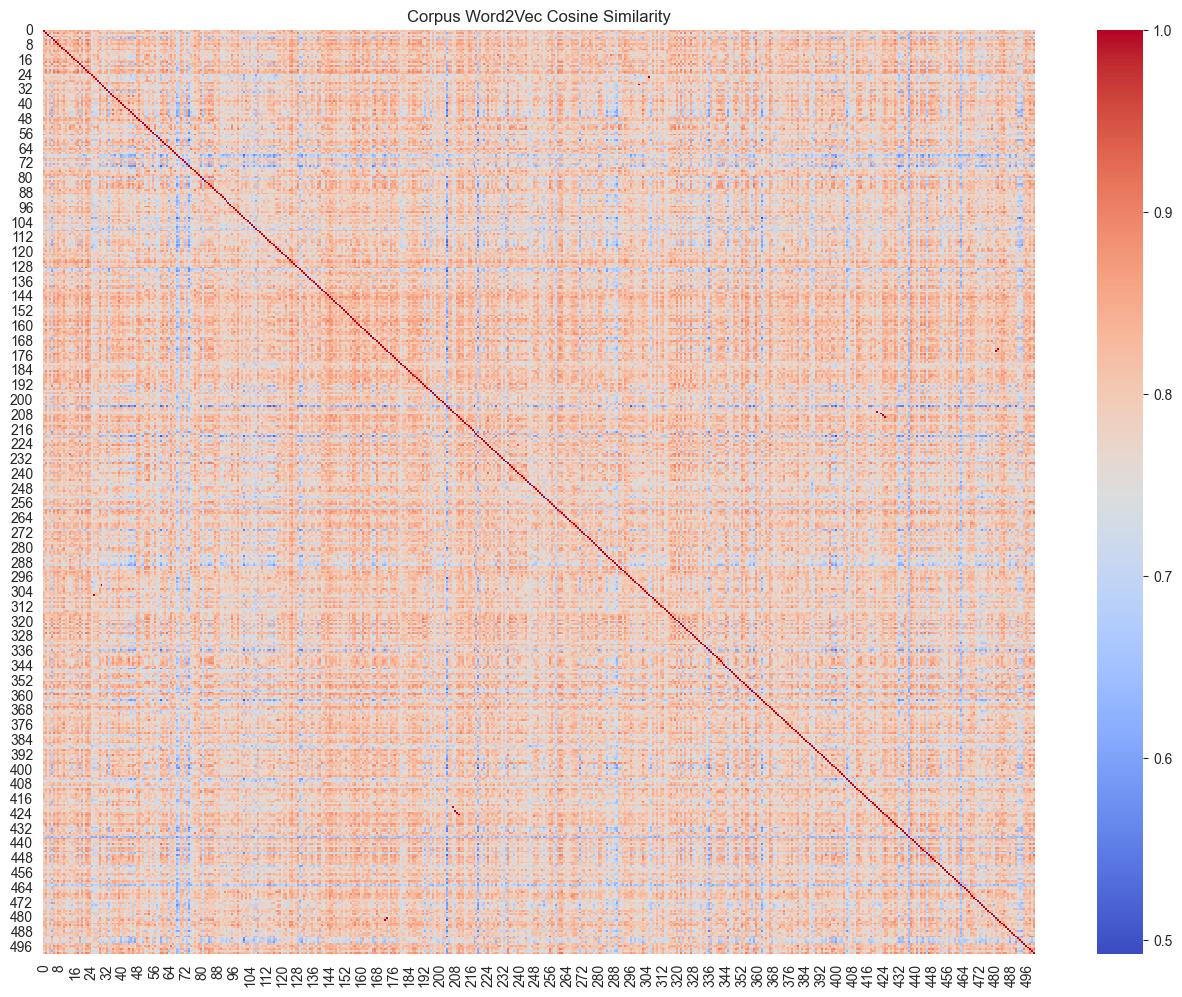

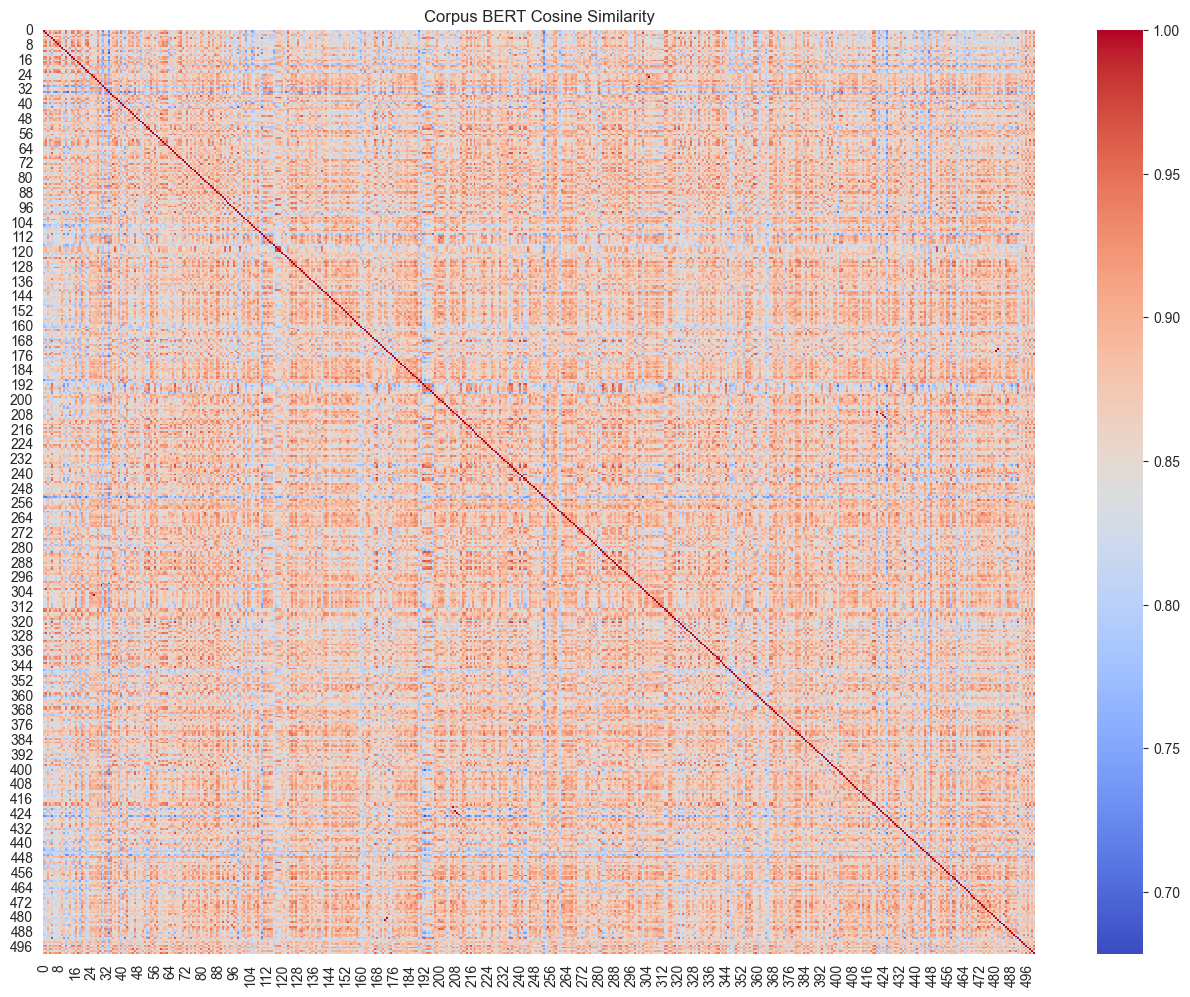

In [12]:
# Plot similarity matrices
plot_similarity_matrix(corpus_word2vec_similarity, "Corpus Word2Vec Cosine Similarity", figsize=(16, 12), annotation=False)
plot_similarity_matrix(corpus_bert_similarity, "Corpus BERT Cosine Similarity", figsize=(16, 12), annotation=False)

Summary

So far, in this exercise, you learned how to:

* Load a pre-trained transformer model (BERT) and a static embedding model (Word2Vec).
* Generate text embeddings using these models.
* Compute cosine similarity between embeddings.
* Compare the similarity results from both contextual and static embeddings.

Now you have a practical understanding of how transformers and embeddings can be used in Information Retrieval systems.

Let's integrate query search.

## Step 7: Generate Embeddings for the Query

Generate embeddings for the query using the same model used for the documents.

In [16]:
total_word2vec_embeddings = generate_word2vec_embeddings(corpus[:1000]) #generar embeddings de palabras para el corpus de texto dado

### Generar representaciones de rmbeddings BERT en paralelo

In [17]:
def parallel_generate_bert_embeddings(all_texts, n_jobs=4):
    chunk_size = len(all_texts) // n_jobs #dividir la lista de textos en sublistas
    text_chunks = [all_texts[i * chunk_size:(i + 1) * chunk_size] for i in range(n_jobs)] #dividir la lista en sublistas
    if len(all_texts) % n_jobs != 0:
        text_chunks.append(all_texts[n_jobs * chunk_size:])

    #inicializar el modelo dentro de la funcion
    def process_chunk(text_chunk):
        local_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        local_model = TFBertModel.from_pretrained('bert-base-uncased')
        embeddings = []
        for text in text_chunk:
            inputs = local_tokenizer(text, return_tensors='tf', padding=True, truncation=True)
            outputs = local_model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token representation
        return np.array(embeddings).transpose(0, 2, 1)

    #procesa cada sublista en paralelo usando backend threading
    with parallel_backend('threading'):
        results = Parallel(n_jobs=n_jobs)(delayed(process_chunk)(chunk) for chunk in text_chunks)

    combined_embeddings = np.concatenate(results, axis=0)
    return combined_embeddings

bert_embeddings_parallel = parallel_generate_bert_embeddings(corpus[:1000], n_jobs=4) #generar embeddings para el corpus usando 4 hilos.

C:\Users\basc6\PycharmProjects\proyect-RI_Soto-Bruce\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model)

#### Generar embeddings para una Query


In [20]:
query = "The wine is completely dry and mature"
query_bert_embeddings = generate_bert_embeddings(query)
query_word2vec_embeddings = generate_word2vec_embeddings(query)

## Step 8: Compute Similarity Between Query and Documents

Compute the similarity between the query embedding and each document embedding.

In [21]:
final_word2vec_similarity = cosine_similarity(query_word2vec_embeddings.reshape(len(query), -1), total_word2vec_embeddings) #calcular la similitud coseno entre los embeddings Word2vec

## Step 9: Retrieve and Rank Documents Based on Similarity Scores

Retrieve and rank the documents based on their similarity scores to the query.

### Rankear documentos basada en similitud coseno

In [22]:
#funcion para word2vec
def rank_documents_word2vec(query, corpus_embeddings):
    query_embedding = generate_word2vec_embeddings([query])[0] #generar embeddings para la consulta
    query_embedding = query_embedding.reshape(1, -1)
    corpus_embeddings = corpus_embeddings.reshape(corpus_embeddings.shape[0], -1)
    similarities = cosine_similarity(query_embedding, corpus_embeddings)[0] #calcular similitud coseno entre la consulta y los documentos
    ranked_indices = np.argsort(-similarities) #obtener los indices ordenados por similitud (de mayor a menor)
    ranked_similarities = similarities[ranked_indices] #ordenar similitudes de mayor a menor
    return ranked_indices, ranked_similarities

#funcion para Bert
def rank_documents_bert(query, corpus_embeddings):
    query_embedding = generate_bert_embeddings([query])[0] #generar embeddings para la consulta
    query_embedding = query_embedding.reshape(1, -1)
    corpus_embeddings = corpus_embeddings.reshape(corpus_embeddings.shape[0], -1)
    similarities = cosine_similarity(query_embedding, corpus_embeddings)[0] #calcular similitud coseno entre la consulta y los documentos
    ranked_indices = np.argsort(-similarities) #obtener los indices ordenados por similitud (de mayor a menor)
    ranked_similarities = similarities[ranked_indices] #ordenar similitudes de mayor a menor
    
    return ranked_indices, ranked_similarities

ranked_indices_word2vec, ranked_similarities_word2vec = rank_documents_word2vec(query, total_word2vec_embeddings)
print("Ranking de documentos con word2vec:", ranked_indices_word2vec)
print("Similitudes correspondientes:", ranked_similarities_word2vec)

ranked_indices_bert, ranked_similarities_bert = rank_documents_bert(query, bert_embeddings_parallel)
print("Ranking de documentos con BERT:", ranked_indices_bert)
print("Similitudes correspondientes:", ranked_similarities_bert)

Ranking de documentos con word2vec: [750 290 688 853 693 577 627  13 396 168 647 733  95 484 903 628 777 933
 997 847 318 572 616 236 909 849  86 287 511 644 408  76 264 344 787 614
 543 434 466 775 931 274  53 110 322 192 526 580 183 241 320 140 848 328
 279 643 544 962   8 995  52 569 380 795 229 910 332 407 574 345 629 911
 772 617 353 218 325 316 941 227 191 278 206 420 293 779 937 352 598 922
 156  56 143  64 633 476 317  98  51 727 535 921 373 193 427 589 205 327
 749 992 648 603 329 134 235 988 661 953 599 788 566 557 291 883 789 809
 790 534 505   4  18 222 682 613 157 214 286 478 895 120 897 588 837 154
 124 454 575 125 907 825 976 740 383 729 249  80 185 755 791 174 908 189
 550 815  22 144 430 618 237 271 592 784 943 663 786 958 288 533 491 276
 602 243 283 830 684 126  74 232 335 202  99 802 739 121 141 413 561 813
 845 404  66 197 493 119   5 761 966 118 989 295 108 123 361 634 934 495
 178  15  23 645 212 819 554 987 957 963 384  11 885 672 272 702 745 220
 512  27 474 47

### Documentos rankeados

In [23]:
#obtener los titulos de los documentos rankeados con Word2Vec y BERT
ranked_titles_word2vec = corpus[ranked_indices_word2vec].values
ranked_titles_bert = corpus[ranked_indices_bert].values

#imprimir los titulos de los documentos rankeados con Word2Vec para la consulta
print(f"Documentos rankeados con Word2Vec para la query: '{query}'\n")
for i, title in enumerate(ranked_titles_word2vec):
    #imprimir el indice del documento y el titulo del documento
    if i >= 70:
        break
        
    print(f"{i+1}. {title}")
    
#imprimir los titulos de los documentos rankeados con BERT para la consulta
print(f"\nDocumentos rankeados por BERT para la query: '{query}'")
for i, title in enumerate(ranked_titles_bert):
    #imprimir el indice del documento y el titulo del documento
    if i >= 70:
        break
    print(f"{i+1}. {title}")

Documentos rankeados con Word2Vec para la query: 'The wine is completely dry and mature'

1. Seduction may be an odd word to use for a Malbec-based wine that is dark and drily tannic. It is structured and firm, with a dry core and black currant fruits. Drink this solid wine from 2017.
2. Still firm and closed, this is a structured wine, solidly tannic with just hints of fruit. It has a dry feel to it, firm, the acidity and red fruits coming through the leathery, dark texture. The wine needs aging, so drink from 2017.
3. A cherry-fresh wine that's so full of fruit that its structure becomes secondary. A dry edge of tannin supports the fruit and acidity, making this wine so drinkable now.
4. Produced from two parcels in Aloxe Corton, this structured wine has red-plum fruitiness that is still masked by a dry tannic coating. It has concentration and good potential. Drink this textured, firm wine from 2018.
5. Entirely sourced from this Sangiacomo family-farmed vineyard, which is planted en